# Fluzz — Détection de fraude bancaire  
**Partie 2 — Comparatif des modèles (Module 2)**

Ce notebook compare 3 algorithmes d'apprentissage automatique pour la détection de fraude bancaire :
- **Régression Logistique** : modèle linéaire simple et interprétable
- **Random Forest** : ensemble d'arbres de décision
- **MLP** (Multi-Layer Perceptron) : réseau de neurones

**Métriques d'évaluation** : F1-Score, Précision, Rappel (adaptées aux classes déséquilibrées)

## 1. Chargement des données et préparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Chargement des données
df = pd.read_csv('../01_data/creditcard.csv')
print(f"Dataset chargé : {df.shape[0]} transactions, {df.shape[1]} features")
print(f"Taux de fraude : {df['Class'].mean()*100:.3f}%")

Dataset chargé : 284807 transactions, 31 features
Taux de fraude : 0.173%


In [2]:
# Séparation des features et de la cible
X = df.drop('Class', axis=1)
y = df['Class']

# Division train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Jeu d'entraînement : {X_train.shape[0]} échantillons")
print(f"Jeu de test : {X_test.shape[0]} échantillons")
print(f"Fraudes dans le test : {y_test.sum()} ({y_test.mean()*100:.3f}%)")

Jeu d'entraînement : 199364 échantillons
Jeu de test : 85443 échantillons
Fraudes dans le test : 148 (0.173%)


In [3]:
# Normalisation des données (nécessaire pour MLP et Régression Logistique)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Données normalisées avec succès")

Données normalisées avec succès


## 2. Entraînement des modèles

In [4]:
# Configuration des modèles avec gestion du déséquilibre
models = {
    'Régression Logistique': LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ),
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=100
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        random_state=42,
        max_iter=500,
        early_stopping=True
    )
}

print("Modèles configurés")

Modèles configurés


In [5]:
# Entraînement des modèles
trained_models = {}

print("Début de l'entraînement...\n")

for name, model in models.items():
    print(f"Entraînement de {name}...")
    
    if name in ['Régression Logistique', 'MLP']:
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train, y_train)
    
    trained_models[name] = model
    print(f"✓ {name} entraîné")

print("\nTous les modèles sont entraînés !")

Début de l'entraînement...

Entraînement de Régression Logistique...
✓ Régression Logistique entraîné
Entraînement de Random Forest...
✓ Random Forest entraîné
Entraînement de MLP...
✓ MLP entraîné

Tous les modèles sont entraînés !


## 3. Évaluation et comparaison

In [6]:
# Évaluation des modèles
results = []

for name, model in trained_models.items():
    # Prédictions
    if name in ['Régression Logistique', 'MLP']:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    # Calcul des métriques
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results.append({
        'Modèle': name,
        'F1-Score': f1,
        'Précision': precision,
        'Rappel': recall
    })
    
    print(f"\n=== {name} ===")
    print(f"F1-Score : {f1:.4f}")
    print(f"Précision : {precision:.4f}")
    print(f"Rappel : {recall:.4f}")

# Création du DataFrame des résultats
results_df = pd.DataFrame(results)
print("\n" + "="*50)
print("RÉSUMÉ DES PERFORMANCES")
print("="*50)
print(results_df.round(4))


=== Régression Logistique ===
F1-Score : 0.1247
Précision : 0.0671
Rappel : 0.8784

=== Random Forest ===
F1-Score : 0.8157
Précision : 0.9720
Rappel : 0.7027

=== MLP ===
F1-Score : 0.8000
Précision : 0.9060
Rappel : 0.7162

RÉSUMÉ DES PERFORMANCES
                  Modèle  F1-Score  Précision  Rappel
0  Régression Logistique    0.1247     0.0671  0.8784
1          Random Forest    0.8157     0.9720  0.7027
2                    MLP    0.8000     0.9060  0.7162


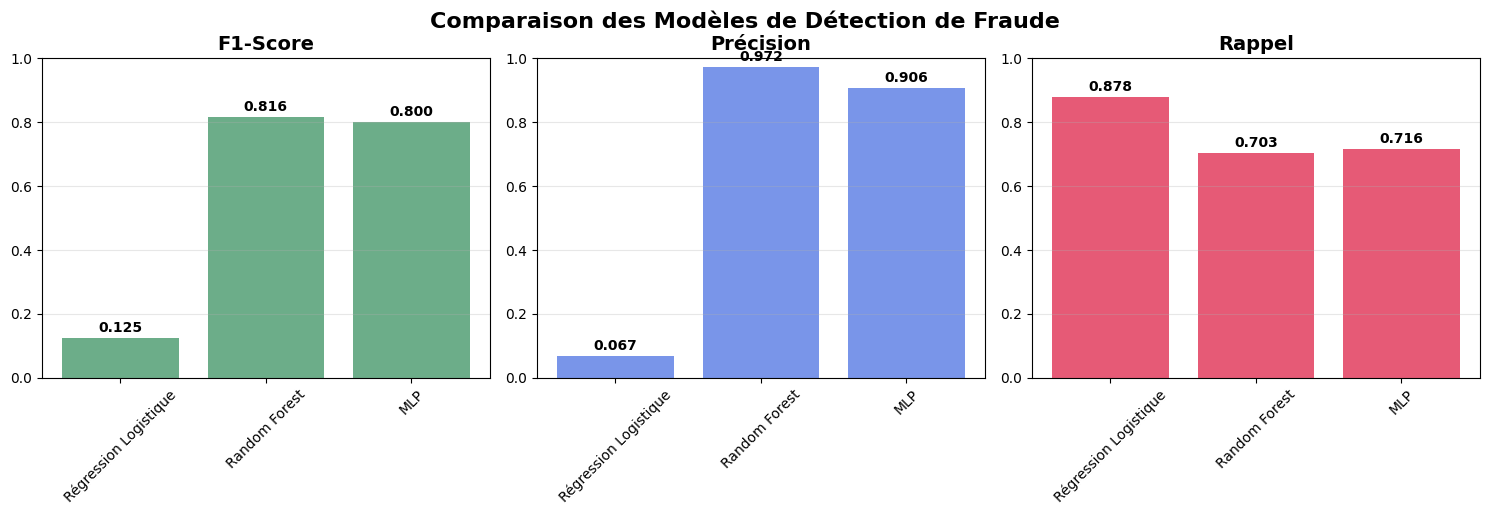

In [7]:
# Visualisation des résultats
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['F1-Score', 'Précision', 'Rappel']
colors = ['#2E8B57', '#4169E1', '#DC143C']

for i, metric in enumerate(metrics):
    bars = axes[i].bar(results_df['Modèle'], results_df[metric], 
                       color=colors[i], alpha=0.7)
    axes[i].set_title(f'{metric}', fontsize=14, fontweight='bold')
    axes[i].set_ylim(0, 1)
    axes[i].grid(axis='y', alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for bar, value in zip(bars, results_df[metric]):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{value:.3f}', ha='center', va='bottom', 
                     fontweight='bold')
    
    # Rotation des labels
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Comparaison des Modèles de Détection de Fraude', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

## 4. Matrices de confusion des 3 modèles

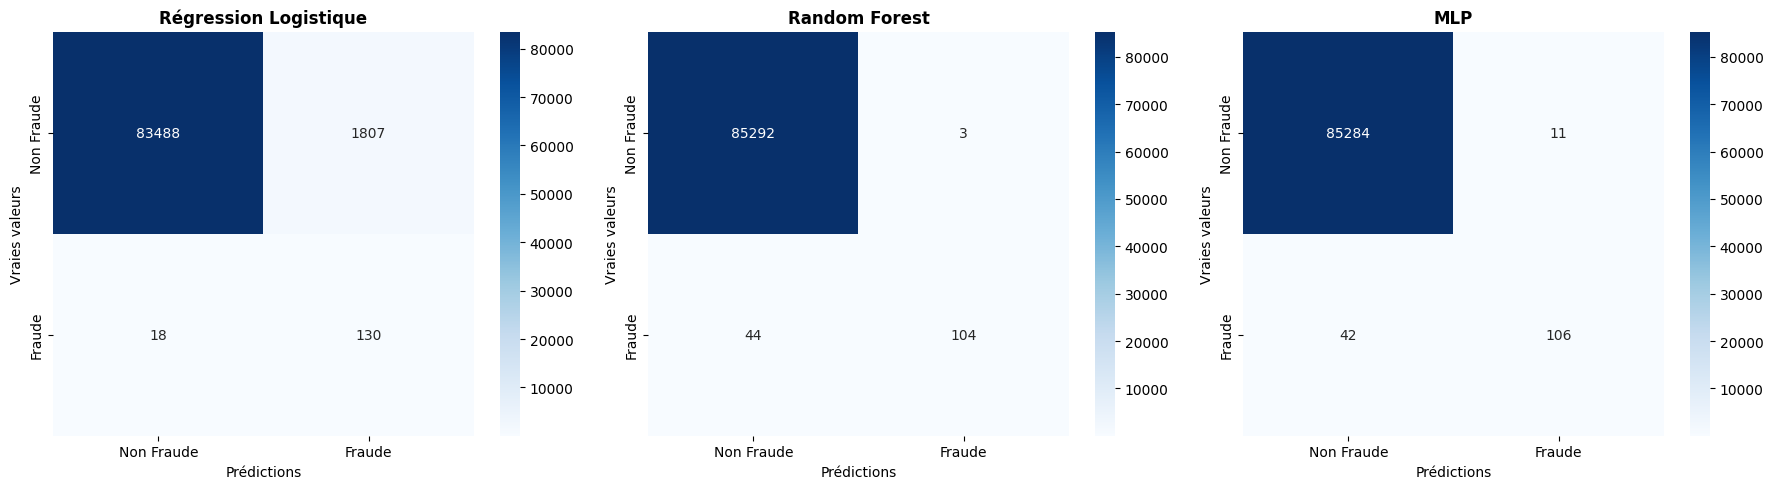

Interprétation des matrices :
• Coin supérieur gauche (TN) : Transactions légitimes correctement identifiées
• Coin supérieur droit (FP) : Fausses alertes (transactions légitimes classées comme fraudes)
• Coin inférieur gauche (FN) : Fraudes manquées (fraudes classées comme légitimes)
• Coin inférieur droit (TP) : Fraudes correctement détectées


In [8]:
# Matrices de confusion pour les 3 modèles
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = list(trained_models.keys())

for i, name in enumerate(model_names):
    model = trained_models[name]
    
    # Prédictions
    if name in ['Régression Logistique', 'MLP']:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    # Affichage
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non Fraude', 'Fraude'],
                yticklabels=['Non Fraude', 'Fraude'],
                ax=axes[i])
    axes[i].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Prédictions')
    axes[i].set_ylabel('Vraies valeurs')

plt.tight_layout()
plt.show()

print("Interprétation des matrices :")
print("• Coin supérieur gauche (TN) : Transactions légitimes correctement identifiées")
print("• Coin supérieur droit (FP) : Fausses alertes (transactions légitimes classées comme fraudes)")
print("• Coin inférieur gauche (FN) : Fraudes manquées (fraudes classées comme légitimes)")
print("• Coin inférieur droit (TP) : Fraudes correctement détectées")

In [9]:
# Tableau récapitulatif des métriques d'erreur pour chaque modèle
error_analysis = []

for name in model_names:
    model = trained_models[name]
    
    # Prédictions
    if name in ['Régression Logistique', 'MLP']:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calcul des taux d'erreur
    false_positive_rate = fp / (fp + tn) * 100  # Taux de fausses alertes
    false_negative_rate = fn / (fn + tp) * 100  # Taux de fraudes manquées
    
    error_analysis.append({
        'Modèle': name,
        'Vrais Positifs (TP)': tp,
        'Faux Positifs (FP)': fp, 
        'Faux Négatifs (FN)': fn,
        'Vrais Négatifs (TN)': tn,
        'Taux Fausses Alertes (%)': round(false_positive_rate, 2),
        'Taux Fraudes Manquées (%)': round(false_negative_rate, 2)
    })

error_df = pd.DataFrame(error_analysis)
print("ANALYSE DÉTAILLÉE DES ERREURS")
print("=" * 80)
display(error_df)

ANALYSE DÉTAILLÉE DES ERREURS


,Modèle,Vrais Positifs (TP),Faux Positifs (FP),Faux Négatifs (FN),Vrais Négatifs (TN),Taux Fausses Alertes (%),Taux Fraudes Manquées (%)
0,Régression Logistique,130,1807,18,83488,2.12,12.16
1,Random Forest,104,3,44,85292,0.00,29.73
2,MLP,106,11,42,85284,0.01,28.38


## 5. Conclusion

### Matrices de confusion - Analyse comparative
Les 3 matrices de confusion permettent de comparer visuellement les performances des modèles :

### Points clés à retenir :
- **Vrais Positifs (TP)** : nombre de fraudes correctement détectées
- **Faux Positifs (FP)** : nombre de fausses alertes (impact sur l'expérience client)
- **Faux Négatifs (FN)** : nombre de fraudes manquées (risque financier)
- **Vrais Négatifs (TN)** : nombre de transactions légitimes correctement identifiées

### Interprétation pour le métier bancaire :
- **Minimiser FP** → réduire les blocages inutiles de cartes clients
- **Minimiser FN** → réduire les pertes financières dues aux fraudes
- **Équilibre FP/FN** → optimiser l'expérience client tout en protégeant la banque

*Vous pouvez maintenant analyser les résultats selon vos priorités métier.*